In [69]:
import xarray as xr
from glob import glob
import pylab as plt
import pandas as pd

from pismragis.analysis import sensitivity_analysis
from pismragis.processing import convert_netcdf_to_dataframe, check_file, copy_file
from pismragis.stats import run_stats

In [70]:
m_files = glob("/import/c1/ICESHEET/ICESHEET/pism-greenland/paleo/2023_10_climate_calving_w_posterior/scalar/ts_gris_ext_g12000m_v2023_GRIMP_id_*_-125001_0.nc")

In [76]:
with xr.open_mfdataset(m_files, combine="nested", concat_dim="id", join="inner", parallel=True) as ds:
    print(ds)

<xarray.Dataset>
Dimensions:                                         (time: 500, id: 15, nv: 2)
Coordinates:
  * time                                            (time) object -124999-01-...
Dimensions without coordinates: id, nv
Data variables: (12/43)
    pism_config                                     (id) int8 0 0 0 0 ... 0 0 0
    run_stats                                       (id) float64 1.854e+195 ....
    time_bounds                                     (id, time, nv) float64 dask.array<chunksize=(1, 500, 2), meta=np.ndarray>
    basal_mass_flux_floating                        (id, time) float64 dask.array<chunksize=(1, 500), meta=np.ndarray>
    basal_mass_flux_grounded                        (id, time) float64 dask.array<chunksize=(1, 500), meta=np.ndarray>
    dt                                              (id, time) float64 dask.array<chunksize=(1, 500), meta=np.ndarray>
    ...                                              ...
    tendency_of_ice_mass_due_to_discharge     

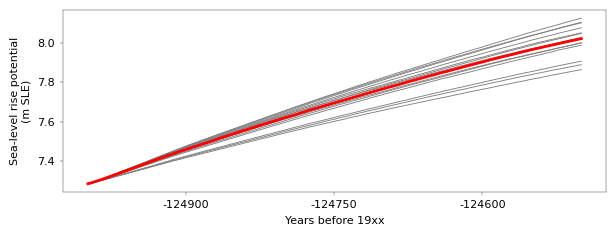

In [77]:
fontsize = 8
lw = 0.65
markersize = 1
params = {
    "axes.linewidth": 0.25,
    "lines.linewidth": lw,
    "axes.labelsize": fontsize,
    "font.size": fontsize,
    "xtick.labelsize": fontsize,
    "xtick.major.size": 2.5,
    "xtick.major.width": 0.25,
    "ytick.labelsize": fontsize,
    "ytick.major.size": 2.5,
    "ytick.major.width": 0.25,
    "legend.fontsize": fontsize,
    "lines.markersize": markersize,
    "font.size": fontsize,
    }

plt.rcParams.update(params)


fig = plt.figure(figsize=[6.2, 2.4])
ax = fig.add_subplot(111)
ds["sea_level_rise_potential"].plot.line(x="time", color="0.5", ax=ax, add_legend=False)
ds["sea_level_rise_potential"].median(dim="id").plot.line(x="time", color="r", lw=2, ax=ax, label="median", add_legend=True)
ax.set_ylabel("Sea-level rise potential\n(m SLE)")
ax.set_xlabel("Years before 19xx")
fig.tight_layout()
fig.savefig("paleo-ensemble-12km.pdf")

In [78]:
ens_df = ds["sea_level_rise_potential"].resample(time="100AS").mean().to_dataframe().reset_index().dropna()

In [79]:
uq_file = "../uncertainty_quantification/gris_paleo_climate-calving_w_posterior_lhs_20.csv"
uq_df = pd.read_csv(uq_file)

In [80]:
sa_df = sensitivity_analysis(ens_df, ensemble_file=uq_file, n_jobs=40, calc_variables=["sea_level_rise_potential"])

-------------------------------------------



Processing date: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]

Program finished in 4 seconds


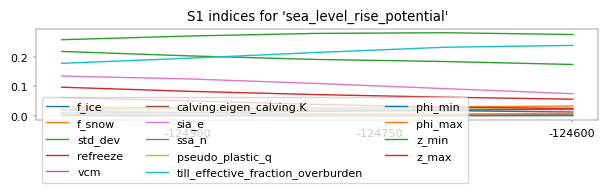

In [89]:
    si = "S1"
    outfile = f"""test.pdf"""
    fig, ax = plt.subplots(
        1,
        1,
        sharex="col",
        figsize=[6.2, 3.8],
    )
    fig.subplots_adjust(bottom=0.0)
    for k, m_var in enumerate(["sea_level_rise_potential"]):
        m_df = sa_df[sa_df["Variable"] == m_var]
        p_df = m_df[m_df["Si"] == si].drop(columns=["Si", "Variable"]).set_index("Date")
        p_conf_df = m_df[m_df["Si"] == si + "_conf"].drop(columns=["Si"])

        [
            ax.plot(p_df.index, p_df[v], lw=1, label=v)
            for v in sa_df.drop(columns=["Si", "Variable", "Date"]).keys()
        ]

        # [
        #     ax.fill_between(
        #         p_df.index,
        #         p_df[v].values - p_conf_df[v].values,
        #         p_df[v].values + p_conf_df[v].values,
        #         alpha=0.2,
        #         lw=0,
        #     )
        #     for v in sa_df.drop(columns=["Si", "Variable", "Date"]).keys()
        # ]
        lgd = ax.set_title(f"{si} indices for '{m_var}'")
    legend = ax.legend(loc="lower left", ncols=3, bbox_to_anchor=(0, -0.75))
    fig.tight_layout()
    fig.savefig(f"{si}_{outfile}")
